In [1]:
USE_DE=True
USE_PE=False
COLAB=False
layer_test_save_path = '/mnt/d/MyDev/attention/models/tmp/'

#  Imports

In [2]:
import pathlib
import os
import re
import pickle
import string
from unicodedata import normalize
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from de_data import DataGen
from positional_encoding import encode_pos_sin_cosine, PositionalEmbedding
from self_attention  import  SelfAttentionV4
from mha import MultiHeadAttentionV3
from add_norm import AddNorm
from positionwise_ff import FeedForward
from encoder_layer import  EncoderLayerV2
from transformer_encoder import TransformerEncoderV3
from decoder_layer import DecoderLayerV3
from transformer_decoder import TransformerDecoderV3
from transformer_model import TransformerModel, TransformerModelV3
from lr_schedular import  CustomSchedule, MyCustomSchedule
from masked_loss_accu import loss_function, accuracy_function
from training_loop import start_training


import warnings

# Suppress TensorFlow logging (1=filter INFO, 2=filter INFO and WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress Python warnings
warnings.filterwarnings('ignore')

import time
import random
random.seed(42)
from random import randint
if COLAB:
 from google.colab import drive
if USE_PE:
  import tensorflow_datasets as tfds
  import tensorflow_text
from pathlib import Path
import pathlib
import scipy
import numpy as np
np.random.seed(123)
import tensorflow as tf

tf.random.set_seed(42)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, SimpleRNN, Dense, LSTM,
     Concatenate, RepeatVector,
    Lambda, Layer, RNN, Embedding, Bidirectional,
    Dot, LayerNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-03-31 16:55:31.573398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-31 16:55:31.587537: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 16:55:31.591581: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 16:55:31.620333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 16:55:35.972783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Colab or local

In [3]:
if COLAB:
  drive.mount('/content/drive')
  fpath = '/content/drive/My Drive/writeups/notebooks/deu.txt'
  # Check if the file exists
  fpath1 = Path(fpath)
  if fpath1.exists():
      print("File exists.")
  else:
      print("File does not exist.")
else:
  fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt'

# Generate Data  DE

In [4]:
n_sentences = 1000
datagen = DataGen(fpath=fpath)
if USE_DE:
    # datagen = DataGen(fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt')
    dataset, lang1, lang2 = datagen.get_cleaned_delimited_data_as_array()
    X1, X2, y, lang1_tokenizer, lang2_tokenizer, en_vocab_size, de_vocab_size, en_seq_len, de_seq_len = \
        datagen.get_source_target_data_n_tokenizer(n_sentences=n_sentences, from_end=True)
example_data_x1 = X1[:2]
example_data_x2 = X2[:2]

195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 40000
['tom came outside' 'sos tom kam nach drauen eos']
(40000, 2)
(40000,)
tom came outside
195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 1000
['i wanted to know if youd heard anything about whats going to be discussed at tomorrows meeting'
 'sos ich wollte wissen ob du irgendetwas daruber gehort hast was auf der sitzung morgen besprochen werden soll eos']
(1000, 2)
(1000,)
i wanted to know if youd heard anything about whats going to be discussed at tomorrows meeting
en

In [5]:
if USE_DE:
    print(lang2_tokenizer.sequences_to_texts([[1]]))
    print(lang2_tokenizer.sequences_to_texts([[2]]))
    print('num for sos=', lang2_tokenizer.texts_to_sequences([['sos']])[0][0])
    print('num for eos=', lang2_tokenizer.texts_to_sequences([['eos']])[0][0])
    example_encoder_input = X1[:1]
    example_decoder_input = X2[:1]

['sos']
['eos']
num for sos= 1
num for eos= 2


# Positional Encoding

## PE function

exponent_i:  (512,)
denominator scalar:  512.0
angle_rates: (512,)
angle_rads: (2048, 512)
sine_values_even: (2048, 256)
cosine_values_odd: (2048, 256)
sin_plus_cos_interleaved: (2048, 512)


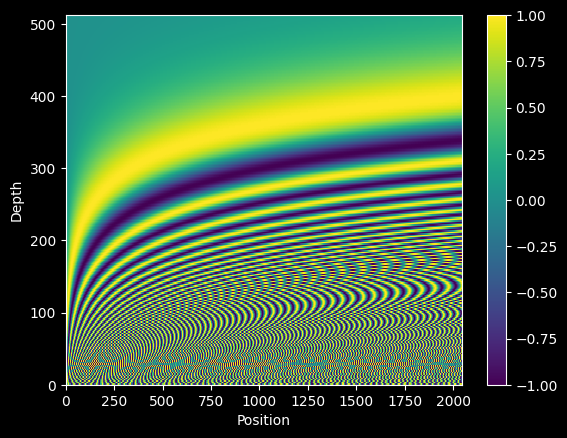

In [6]:
positional_encodings = encode_pos_sin_cosine(2048, 512, debug=True)
plt.style.use('dark_background')
plt.pcolormesh(positional_encodings.T)
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## PE class

In [7]:
d_model=512
pos_embedding = PositionalEmbedding(en_vocab_size, d_model)
embedded_data = pos_embedding(X1[:1], training=False)
print('embedded_data shape:', embedded_data.shape)
# print('embedded_data shape:', embedded_data[0][3])
print('embedded_data mask', embedded_data._keras_mask)

# save_path = '/mnt/d/MyDev/attention/models/tmp/'
# tf.saved_model.save(pos_embedding, 
#                     save_path, 
#                     signatures={'serving_default': pos_embedding.serve})

embedded_data shape: (1, 101, 512)
embedded_data mask tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]], shape=(1, 101), dtype=bool)


#  Self Attention

In [8]:
# Example usage:
d_model = 512  # Dimensionality of model embeddings
d_k = 64  # Dimensionality of keys and queries (often d_model // num_heads)
d_v = 64  # Dimensionality of values
tf.config.run_functions_eagerly(True)
self_attention = SelfAttentionV4(d_model, d_k, d_v, 
                                 row_mask_to_sero=True,
                                 use_masked_softmax=False,
                                 debug=True)
attention_output = self_attention(
    embedded_data, embedded_data, embedded_data
    )
tf.config.run_functions_eagerly(False)
# print('attention_weights from instance:', self_attention.attention_weights.shape)

scores(1, 101, 101) b4 mask = q(1, 101, 64) X kT(1, 101, 64)
col mask equivallent query mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]]
scores(1, 101, 101) b4 mask = q(1, 101, 64) X kT(1, 101, 64)
col mask equivallent query mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False 

In [9]:
### CAUSAL MASK TESTING
self_attention = SelfAttentionV4(d_model, d_k, d_v, debug=True)
attention_output = self_attention(
    embedded_data, embedded_data, embedded_data, 
    # num_heads=8,
    # mask=embedded_data._keras_mask,
   use_causal_mask=True)
print('attention_weights from instance:', self_attention.attention_weights.shape)

scores(1, 101, 101) b4 mask = q(1, 101, 64) X kT(1, 101, 64)
col mask equivallent query mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]]
scores(1, 101, 101) b4 mask = q(1, 101, 64) X kT(1, 101, 64)
col mask equivallent query mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False 

# Multi head attention

In [10]:
num_heads = 8
multihead_attention = MultiHeadAttentionV3(num_heads, d_model, debug=True)
attention_output = multihead_attention(
        embedded_data, embedded_data, embedded_data, training=False,
        num_heads=8,
        # mask=embedded_data._keras_mask
    )
attention_weights = multihead_attention.attention_weights
print("Final Attention Output from Dense layer Shape:", attention_output.shape)
print("Attention Weights Shape:", attention_weights.shape)
print('attention weight first head:', attention_weights[0])

q b4 split head: (1, 101, 512)
q after split head: (1, 8, 101, 64)
k b4 split head: (1, 101, 512)
k after split head: (1, 8, 101, 64)
v b4 split head: (1, 101, 512)
v after split head: (1, 8, 101, 64)
q preprared for selfattention(batch_cross_numheads): (8, 101, 64)
k, v preprared for selfattention(batch_cross_numheads): (8, 101, 64)
scores(8, 101, 101) b4 mask = q(8, 101, 64) X kT(8, 101, 64)
col mask equivallent query mask: [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False Fa

In [11]:
# attention_weights

# Layer Normalization

In [12]:
addnorm = AddNorm()
add_norm_out = addnorm(embedded_data, attention_output)
print('add_norm_out:', add_norm_out.shape)
'''
This layer can not be saved due to norm operation. During saving , the shape of the tensor is not detected
'''


add_norm_out: (1, 101, 512)


'\nThis layer can not be saved due to norm operation. During saving , the shape of the tensor is not detected\n'

####  error saving / serializing

In [13]:
# dynamic_serve = addnorm.get_dynamic_serve_function()
# wrapped_dynamic_serve = tf.function(
#     func=dynamic_serve,
#     input_signature=[
#         tf.TensorSpec(shape=embedded_data.shape, dtype=tf.float32),
#         tf.TensorSpec(shape=attention_output.shape, dtype=tf.float32)
#     ]
# )
# tf.saved_model.save(addnorm, 
#                     layer_test_save_path, 
#                     signatures={'serving_default': wrapped_dynamic_serve})



---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[11], line 15
      7 dynamic_serve = addnorm.get_dynamic_serve_function()
      8 wrapped_dynamic_serve = tf.function(
      9     func=dynamic_serve,
     10     input_signature=[
   (...)
     13     ]
     14 )
---> 15 tf.saved_model.save(addnorm, 
     16                     layer_test_save_path, 
     17                     signatures={'serving_default': wrapped_dynamic_serve})

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1392, in save(obj, export_dir, signatures, options)
   1390 # pylint: enable=line-too-long
   1391 metrics.IncrementWriteApi(_SAVE_V2_LABEL)
-> 1392 save_and_return_nodes(obj, export_dir, signatures, options)
   1394 metrics.IncrementWrite(write_version="2")

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1427, in save_and_return_nodes(obj, export_dir, signatures, options, experimental_skip_checkpoint)
   1423 saved_model = saved_model_pb2.SavedModel()
   1424 meta_graph_def = saved_model.meta_graphs.add()
   1426 _, exported_graph, object_saver, asset_info, saved_nodes, node_paths = (
-> 1427     _build_meta_graph(obj, signatures, options, meta_graph_def))
   1428 saved_model.saved_model_schema_version = (
   1429     constants.SAVED_MODEL_SCHEMA_VERSION)
   1431 # Write the checkpoint, copy assets into the assets directory, and write out
   1432 # the SavedModel proto itself.

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1642, in _build_meta_graph(obj, signatures, options, meta_graph_def)
   1615 """Creates a MetaGraph under a save context.
   1616 
   1617 Args:
   (...)
   1638   saveable_view.node_paths: _SaveableView paths.
   1639 """
   1641 with save_context.save_context(options):
-> 1642   return _build_meta_graph_impl(obj, signatures, options, meta_graph_def)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1559, in _build_meta_graph_impl(obj, signatures, options, meta_graph_def)
   1552   signatures = signature_serialization.find_function_to_export(
   1553       augmented_graph_view
   1554   )
   1556 signatures, wrapped_functions, defaults = (
   1557     signature_serialization.canonicalize_signatures(signatures)
   1558 )
-> 1559 signature_serialization.validate_augmented_graph_view(augmented_graph_view)
   1560 signature_map = signature_serialization.create_signature_map(signatures)
   1561 augmented_graph_view.set_signature(signature_map, wrapped_functions)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/signature_serialization.py:364, in validate_augmented_graph_view(augmented_graph_view)
    362 def validate_augmented_graph_view(augmented_graph_view):
    363   """Performs signature-related sanity checks on `augmented_graph_view`."""
--> 364   for name, dep in augmented_graph_view.list_children(
    365       augmented_graph_view.root
    366   ):
    367     if name == SIGNATURE_ATTRIBUTE_NAME:
    368       if not isinstance(dep, _SignatureMap):

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:190, in _AugmentedGraphView.list_children(self, obj)
    187 if obj not in self._children_cache:
    188   children = self._children_cache[obj] = {}
--> 190   for name, child in super(_AugmentedGraphView, self).list_children(
    191       obj,
    192       save_type=base.SaveType.SAVEDMODEL,
    193       cache=self._serialization_cache):
    194     if isinstance(child, defun.ConcreteFunction):
    195       child = self._maybe_uncache_variable_captures(child)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/checkpoint/graph_view.py:75, in ObjectGraphView.list_children(self, obj, save_type, **kwargs)
     64 """Returns list of all child trackables attached to obj.
     65 
     66 Args:
   (...)
     72   List of all children attached to the object.
     73 """
     74 children = []
---> 75 for name, ref in super(ObjectGraphView,
     76                        self).children(obj, save_type, **kwargs).items():
     77   children.append(base.TrackableReference(name, ref))
     79 # GraphView objects may define children of the root object that are not
     80 # actually attached, e.g. a Checkpoint object's save_counter.

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/checkpoint/trackable_view.py:84, in TrackableView.children(cls, obj, save_type, **kwargs)
     82 obj._maybe_initialize_trackable()
     83 children = {}
---> 84 for name, ref in obj._trackable_children(save_type, **kwargs).items():
     85   ref = converter.convert_to_trackable(ref, parent=obj)
     86   children[name] = ref

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/keras/src/backend/tensorflow/layer.py:57, in TFLayer._trackable_children(self, save_type, **kwargs)
     54     self.test_function = None
     55     self.predict_function = None
---> 57 children = super()._trackable_children(save_type, **kwargs)
     59 if save_type == "savedmodel":
     60     self.train_function = train_function

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/trackable/autotrackable.py:115, in AutoTrackable._trackable_children(self, save_type, **kwargs)
    113 for fn in functions.values():
    114   if isinstance(fn, def_function.Function):
--> 115     fn._list_all_concrete_functions_for_serialization()  # pylint: disable=protected-access
    117 # Additional dependencies may have been generated during function tracing
    118 # (e.g. captured variables). Make sure we return those too.
    119 children = {}

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:1186, in Function._list_all_concrete_functions_for_serialization(self)
   1184 concrete_functions = []
   1185 for args, kwargs in seen_signatures:
-> 1186   concrete_functions.append(self.get_concrete_function(*args, **kwargs))
   1187 return concrete_functions

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:1251, in Function.get_concrete_function(self, *args, **kwargs)
   1249 def get_concrete_function(self, *args, **kwargs):
   1250   # Implements PolymorphicFunction.get_concrete_function.
-> 1251   concrete = self._get_concrete_function_garbage_collected(*args, **kwargs)
   1252   concrete._garbage_collector.release()  # pylint: disable=protected-access
   1253   return concrete

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:1221, in Function._get_concrete_function_garbage_collected(self, *args, **kwargs)
   1219   if self._variable_creation_config is None:
   1220     initializers = []
-> 1221     self._initialize(args, kwargs, add_initializers_to=initializers)
   1222     self._initialize_uninitialized_variables(initializers)
   1224 if self._created_variables:
   1225   # In this case we have created variables on the first call, so we run the
   1226   # version which is guaranteed to never create variables.

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:696, in Function._initialize(self, args, kwds, add_initializers_to)
    691 self._variable_creation_config = self._generate_scoped_tracing_options(
    692     variable_capturing_scope,
    693     tracing_compilation.ScopeType.VARIABLE_CREATION,
    694 )
    695 # Force the definition of the function for these arguments
--> 696 self._concrete_variable_creation_fn = tracing_compilation.trace_function(
    697     args, kwds, self._variable_creation_config
    698 )
    700 def invalid_creator_scope(*unused_args, **unused_kwds):
    701   """Disables variable creation."""

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py:178, in trace_function(args, kwargs, tracing_options)
    175     args = tracing_options.input_signature
    176     kwargs = {}
--> 178   concrete_function = _maybe_define_function(
    179       args, kwargs, tracing_options
    180   )
    182 if not tracing_options.bind_graph_to_function:
    183   concrete_function._garbage_collector.release()  # pylint: disable=protected-access

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py:283, in _maybe_define_function(args, kwargs, tracing_options)
    281 else:
    282   target_func_type = lookup_func_type
--> 283 concrete_function = _create_concrete_function(
    284     target_func_type, lookup_func_context, func_graph, tracing_options
    285 )
    287 if tracing_options.function_cache is not None:
    288   tracing_options.function_cache.add(
    289       concrete_function, current_func_context
    290   )

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py:310, in _create_concrete_function(function_type, type_context, func_graph, tracing_options)
    303   placeholder_bound_args = function_type.placeholder_arguments(
    304       placeholder_context
    305   )
    307 disable_acd = tracing_options.attributes and tracing_options.attributes.get(
    308     attributes_lib.DISABLE_ACD, False
    309 )
--> 310 traced_func_graph = func_graph_module.func_graph_from_py_func(
    311     tracing_options.name,
    312     tracing_options.python_function,
    313     placeholder_bound_args.args,
    314     placeholder_bound_args.kwargs,
    315     None,
    316     func_graph=func_graph,
    317     add_control_dependencies=not disable_acd,
    318     arg_names=function_type_utils.to_arg_names(function_type),
    319     create_placeholders=False,
    320 )
    322 transform.apply_func_graph_transforms(traced_func_graph)
    324 graph_capture_container = traced_func_graph.function_captures

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:1059, in func_graph_from_py_func(name, python_func, args, kwargs, signature, func_graph, add_control_dependencies, arg_names, op_return_value, collections, capture_by_value, create_placeholders)
   1056   return x
   1058 _, original_func = tf_decorator.unwrap(python_func)
-> 1059 func_outputs = python_func(*func_args, **func_kwargs)
   1061 # invariant: `func_outputs` contains only Tensors, CompositeTensors,
   1062 # TensorArrays and `None`s.
   1063 func_outputs = variable_utils.convert_variables_to_tensors(func_outputs)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:599, in Function._generate_scoped_tracing_options.<locals>.wrapped_fn(*args, **kwds)
    595 with default_graph._variable_creator_scope(scope, priority=50):  # pylint: disable=protected-access
    596   # __wrapped__ allows AutoGraph to swap in a converted function. We give
    597   # the function a weak reference to itself to avoid a reference cycle.
    598   with OptionalXlaContext(compile_with_xla):
--> 599     out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    600   return out

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py:1719, in class_method_to_instance_method.<locals>.bound_method_wrapper(*args, **kwargs)
   1714   return wrapped_fn(weak_instance(), *args, **kwargs)
   1716 # If __wrapped__ was replaced, then it is always an unbound function.
   1717 # However, the replacer is still responsible for attaching self properly.
   1718 # TODO(mdan): Is it possible to do it here instead?
-> 1719 return wrapped_fn(*args, **kwargs)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py:52, in py_func_from_autograph.<locals>.autograph_handler(*args, **kwargs)
     50 except Exception as e:  # pylint:disable=broad-except
     51   if hasattr(e, "ag_error_metadata"):
---> 52     raise e.ag_error_metadata.to_exception(e)
     53   else:
     54     raise

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py:41, in py_func_from_autograph.<locals>.autograph_handler(*args, **kwargs)
     39 """Calls a converted version of original_func."""
     40 try:
---> 41   return api.converted_call(
     42       original_func,
     43       args,
     44       kwargs,
     45       options=converter.ConversionOptions(
     46           recursive=True,
     47           optional_features=autograph_options,
     48           user_requested=True,
     49       ))
     50 except Exception as e:  # pylint:disable=broad-except
     51   if hasattr(e, "ag_error_metadata"):

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:439, in converted_call(f, args, kwargs, caller_fn_scope, options)
    437 try:
    438   if kwargs is not None:
--> 439     result = converted_f(*effective_args, **kwargs)
    440   else:
    441     result = converted_f(*effective_args)

File /tmp/__autograph_generated_filehb54u7v0.py:12, in outer_factory.<locals>.inner_factory.<locals>.tf__serve(self, inputs, sublayer_output)
     10 try:
     11     do_return = True
---> 12     retval_ = {'output': ag__.converted_call(ag__.ld(self), (ag__.ld(inputs), ag__.ld(sublayer_output)), None, fscope)}
     13 except:
     14     do_return = False

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:331, in converted_call(f, args, kwargs, caller_fn_scope, options)
    329 if conversion.is_in_allowlist_cache(f, options):
    330   logging.log(2, 'Allowlisted %s: from cache', f)
--> 331   return _call_unconverted(f, args, kwargs, options, False)
    333 if ag_ctx.control_status_ctx().status == ag_ctx.Status.DISABLED:
    334   logging.log(2, 'Allowlisted: %s: AutoGraph is disabled in context', f)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:460, in _call_unconverted(f, args, kwargs, options, update_cache)
    458 if kwargs is not None:
    459   return f(*args, **kwargs)
--> 460 return f(*args)

File /mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py:123, in filter_traceback.<locals>.error_handler(*args, **kwargs)
    120     filtered_tb = _process_traceback_frames(e.__traceback__)
    121     # To get the full stack trace, call:
    122     # `keras.config.disable_traceback_filtering()`
--> 123     raise e.with_traceback(filtered_tb) from None
    124 finally:
    125     del filtered_tb

File /mnt/d/mydev/attention/add_norm.py:24, in AddNorm.call(self, inputs, sublayer_output)
     20 def call(self, inputs, sublayer_output):
     21     # inputs: output from the previous layer
     22     # sublayer_output: output from the self-attention or feedforward network
     23     x = self.add([inputs, sublayer_output])
---> 24     x = self.norm(x)       
     25     return x

TypeError: in user code:

    File "/mnt/d/mydev/attention/add_norm.py", line 41, in serve  *
        return {'output': self(inputs, sublayer_output)}
    File "/mnt/d/mydev/attention/wslvenvtftutorial/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 123, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/mnt/d/mydev/attention/add_norm.py", line 24, in call
        x = self.norm(x)

    TypeError: Exception encountered when calling LayerNormalization.call().
    
    Failed to convert elements of [1, 1, None] to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
    
    Arguments received by LayerNormalization.call():
      • inputs=tf.Tensor(shape=(None, None, None), dtype=float32)

#  Position-wise Feed Forward

In [14]:
dff = 2048
ffn = FeedForward(d_model, dff)
ffn_out = ffn(add_norm_out)
print('ffn_out:', ffn_out.shape)

tf.saved_model.save(ffn, 
                    layer_test_save_path, 
                    signatures={'serving_default': ffn.serve})

ffn_out: (1, 101, 512)
INFO:tensorflow:Assets written to: /mnt/d/MyDev/attention/models/tmp/assets


INFO:tensorflow:Assets written to: /mnt/d/MyDev/attention/models/tmp/assets


# Encoder Layer

In [15]:
dff = 2048
enc_layer = EncoderLayerV2(d_model, num_heads, dff)
enc_layer_out = enc_layer(embedded_data, training=False)
atten_weights = enc_layer.attention_weights
print('enc_layer_out:', enc_layer_out.shape)
print('atten_weights from instance:', atten_weights.shape)

# tf.saved_model.save(enc_layer, 
#                     layer_test_save_path, 
#                     signatures={'serving_default': enc_layer.serve})

enc_layer_out: (1, 101, 512)
atten_weights from instance: (8, 101, 101)


# Transformer  Encoder 

In [16]:
num_heads

8

In [17]:
num_layers=6
encoder = TransformerEncoderV3(num_layers, d_model, num_heads, dff,
                             vocab_size=en_vocab_size, debug=True)
encoder_out = encoder(X1[:2], training=False) ### Take more than 1 datapoint in a batch to test the batch
print('encoder_out:', encoder_out.shape)

num_heads at encoder call : 8
mask received at encoder layer: (2, 101)
q b4 split head: (2, 101, 512)
q after split head: (2, 8, 101, 64)
k b4 split head: (2, 101, 512)
k after split head: (2, 8, 101, 64)
v b4 split head: (2, 101, 512)
v after split head: (2, 8, 101, 64)
q preprared for selfattention(batch_cross_numheads): (16, 101, 64)
k, v preprared for selfattention(batch_cross_numheads): (16, 101, 64)
scores(16, 101, 101) b4 mask = q(16, 101, 64) X kT(16, 101, 64)
scores(16, 101, 101) b4 mask = q(16, 101, 64) X kT(16, 101, 64)
q b4 split head: (2, 101, 512)
q after split head: (2, 8, 101, 64)
k b4 split head: (2, 101, 512)
k after split head: (2, 8, 101, 64)
v b4 split head: (2, 101, 512)
v after split head: (2, 8, 101, 64)
q preprared for selfattention(batch_cross_numheads): (16, 101, 64)
k, v preprared for selfattention(batch_cross_numheads): (16, 101, 64)
scores(16, 101, 101) b4 mask = q(16, 101, 64) X kT(16, 101, 64)
num_heads at encoder call : 8
mask received at encoder layer:

# Decoder Layer

# Transformer Decoder

In [18]:
trans_decoder = TransformerDecoderV3(1, d_model, num_heads, dff, en_vocab_size, debug=True)
trans_decoder_out, _ = trans_decoder(X2[:2], encoder_out, training=False) ### Take more than 1 datapoint in a batch to test the batch . Do the same thing with encoder
print('trans_decoder_out:', trans_decoder_out.shape)

mask for decoder input: Tensor("NotEqual:0", shape=(2, 76), dtype=bool)
x sqrt:  (2, 76, 512)
start decoder masked multihead :
q b4 split head: (2, 76, 512)
q after split head: (2, 8, 76, 64)
k b4 split head: (2, 76, 512)
k after split head: (2, 8, 76, 64)
v b4 split head: (2, 76, 512)
v after split head: (2, 8, 76, 64)
q preprared for selfattention(batch_cross_numheads): (16, 76, 64)
k, v preprared for selfattention(batch_cross_numheads): (16, 76, 64)
scores(16, 76, 76) b4 mask = q(16, 76, 64) X kT(16, 76, 64)
scores(16, 76, 76) b4 mask = q(16, 76, 64) X kT(16, 76, 64)
q b4 split head: (2, 76, 512)
q after split head: (2, 8, 76, 64)
k b4 split head: (2, 76, 512)
k after split head: (2, 8, 76, 64)
v b4 split head: (2, 76, 512)
v after split head: (2, 8, 76, 64)
q preprared for selfattention(batch_cross_numheads): (16, 76, 64)
k, v preprared for selfattention(batch_cross_numheads): (16, 76, 64)
scores(16, 76, 76) b4 mask = q(16, 76, 64) X kT(16, 76, 64)
start decoder masked multihead :


# Transformer Model

In [19]:
tf.config.run_functions_eagerly(True)
transformer = TransformerModelV3(2, 64, 2, dff,
                               en_vocab_size, de_vocab_size, en_seq_len,
                               de_seq_len, 
                                row_mask_to_sero=True,
                                 use_masked_softmax=False,
                                 debug=True)
transformer_out = transformer((X1[:2], X2[:2]), training=False)
key = list(transformer.attention_weights.keys())[-1]
transformer_weights = transformer.attention_weights[key]
print('transformer_out:', transformer_out.shape)
print('transformer_weights from instance:', transformer_weights.shape)
tf.config.run_functions_eagerly(False)

mask for decoder input: Tensor("NotEqual:0", shape=(2, 76), dtype=bool)
x sqrt:  (2, 76, 64)
start decoder masked multihead :
q b4 split head: (2, 76, 64)
q after split head: (2, 2, 76, 32)
k b4 split head: (2, 76, 64)
k after split head: (2, 2, 76, 32)
v b4 split head: (2, 76, 64)
v after split head: (2, 2, 76, 32)
q preprared for selfattention(batch_cross_numheads): (4, 76, 32)
k, v preprared for selfattention(batch_cross_numheads): (4, 76, 32)
scores(4, 76, 76) b4 mask = q(4, 76, 32) X kT(4, 76, 32)
scores(4, 76, 76) b4 mask = q(4, 76, 32) X kT(4, 76, 32)
q b4 split head: (2, 76, 64)
q after split head: (2, 2, 76, 32)
k b4 split head: (2, 76, 64)
k after split head: (2, 2, 76, 32)
v b4 split head: (2, 76, 64)
v after split head: (2, 2, 76, 32)
q preprared for selfattention(batch_cross_numheads): (4, 76, 32)
k, v preprared for selfattention(batch_cross_numheads): (4, 76, 32)
scores(4, 76, 76) b4 mask = q(4, 76, 32) X kT(4, 76, 32)
start decoder masked multihead :
q b4 split head: (2,

# LR schedular 

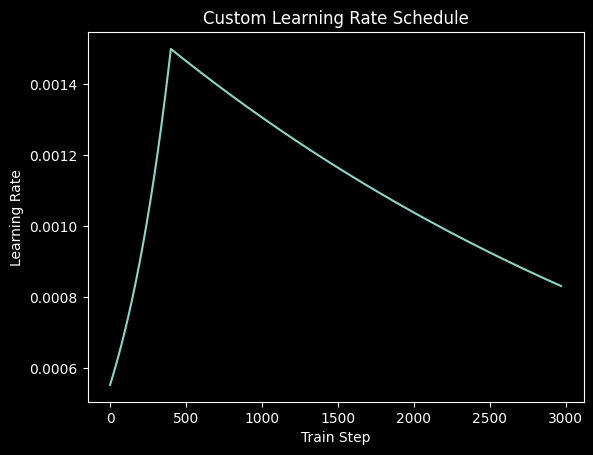

In [20]:
# Example usage
learning_rate = MyCustomSchedule(d_model=128)
plt.plot(learning_rate(tf.range(2969, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.title('Custom Learning Rate Schedule')
plt.show()

Text(0.5, 0, 'Train Step')

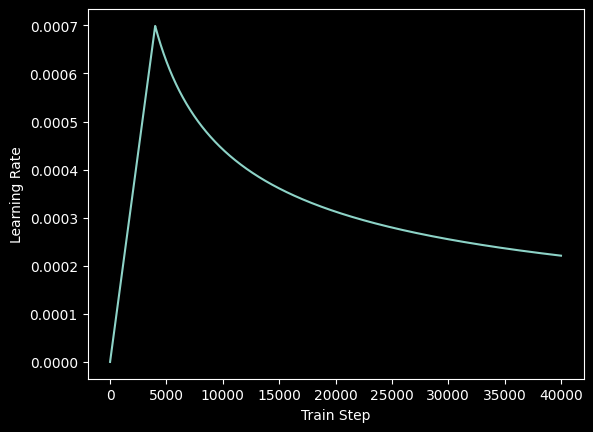

In [21]:

learning_rate = CustomSchedule(d_model=512)
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# Hyper parameters

In [22]:
num_layers, d_model, num_heads, dff = 2, 512, 8, 512
pos_dropout, en_dropout, de_dropout = 0.2, 0.2, 0.2

# Plot Functions

####  Plot function

In [23]:
def id_to_token_in_vocab(ids, tokenizer=lang1_tokenizer):
    # Convert a single ID to a sequence by wrapping it in a list of lists
    sequences = [[id] for id in ids]
    # Use sequences_to_texts to convert these sequences back to text
    texts = tokenizer.sequences_to_texts(sequences)
    # sequences_to_texts returns a list of text strings
    return texts

def id_to_token_out_vocab(ids, tokenizer=lang2_tokenizer):
    sequences = [[id] for id in ids]
    texts = tokenizer.sequences_to_texts(sequences)
    return texts


def plot_attention_weights(encoder_input, decoder_input,
                           attention_weights, layer=None,
                           lang1_tokenizer=lang1_tokenizer,
                           lang2_tokenizer=lang2_tokenizer,
                          figsize=(12, 15),
                          nrows=2, ncols=4):
    # Assuming 'attention_weights[layer]' is of shape (num_heads, seq_len_decoder, seq_len_encoder)
    num_heads = attention_weights.shape[0]   #attention_weights[layer].shape[0]
    seq_len_decoder = attention_weights.shape[1]  ### attention_weights[layer].shape[1]
    seq_len_encoder = attention_weights.shape[2]

    # Set up the matplotlib figure and axes, based on the number of heads
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=figsize)

    # If there's only one head, matplotlib doesn't return an array of axes
    if num_heads == 1:
        axes = np.array([axes])

    encoder_input_tokens = id_to_token_in_vocab(encoder_input[0], lang1_tokenizer)
    decoder_input_tokens = id_to_token_out_vocab(decoder_input[0], lang2_tokenizer)

    # Flatten the list of tokens if they are returned as list of lists
    encoder_input_tokens = [token for sublist in encoder_input_tokens for token in sublist.split()]
    decoder_input_tokens = [token for sublist in decoder_input_tokens for token in sublist.split()]
    len_en_token = len(encoder_input_tokens)
    len_de_token = len(decoder_input_tokens)
    for head, ax in zip(range(num_heads), axes.flatten()):
        # ax = axes[head]
        # attention_head_weights = attention_weights[layer][head]
        # print('head:', head)
        attention_head_weights = attention_weights[head]
        # print('attention_head_weights:', attention_head_weights.shape)
        cax = ax.matshow(attention_head_weights[:len_de_token, :len_en_token], cmap='viridis')

        ax.set_xticks(range(len(encoder_input_tokens)))
        ax.set_yticks(range(len(decoder_input_tokens[1:])))

        ax.set_xticklabels(encoder_input_tokens, rotation=90)
        ax.set_yticklabels(decoder_input_tokens[1:])

        ax.set_title(f'Head {head+1}')

    # plt.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.tight_layout()
    plt.show()

### function show_plot

In [24]:
def show_plot(start=1, end=110, n=1,  ####sample_decoder_input[:,:-1]
             layer='decoder_layer5_block2'):
    random_integers = [random.randint(start, end) for _ in range(n)]
    for n in random_integers:
        print(n)
        sample_encoder_input = X1[n:n+1]  # Select a sample input
        sample_decoder_input = X2[n:n+1] ###[:,:-1]  # Select a corresponding target input
        print('sample_decoder_input:\n', sample_decoder_input)
        prediction_out, attention_weights_n = loaded_model(
            [sample_encoder_input, sample_decoder_input], training=False)
        print('prediction_out:\n', prediction_out.shape)
        predicted_id = np.argmax(prediction_out, axis=-1)
        print('predicted_id:\n', predicted_id)
        print('predicted label:\n', y[n:n+1])
        layer = list(transformer_weights.keys())[-1]
        attention_weights_n = attention_weights_n[layer]
        # attention_weights_n = trained_transformer.decoder.dec_layers[-1].last_attn_scores
        # attention_weights_n = tf.squeeze(attention_weights_n, axis=0)
        print('attn_scores: ' , attention_weights_n.shape)
        plot_attention_weights(sample_encoder_input, 
                               sample_decoder_input, 
                               attention_weights_n)
# show_plot(n=1)

In [25]:
# can we integrate the training with model.fit 
# check performance with more data 

#  Fit method to train

In [26]:
fit_model = TransformerModelV3(num_layers,
                                   d_model,
                                   num_heads, dff,
                                   en_vocab_size,
                                   de_vocab_size,
                                   en_seq_len,
                                   de_seq_len,
                               row_mask_to_sero=True,
                                 use_masked_softmax=True,
                                   debug=False)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
            learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adam()
fit_model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=[accuracy_function]
)


#  Data to tensor batches

In [27]:
print(X1[0:1])
print(X2[0:1])
print(y[:1])
X1.shape
type(X1)

[[  7  75  80   2 602  11  55   9   7  59 162   1  98 603 216   9 172 174
  600   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]]
[[   1    5  272   59   10   25  263   10    5  109   41    3 1054  119
   259    3    5  219  468   44    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[   5  272   59   10   25  263   10    5  109   41    3 1054  119  259
     3    5  219  468   44    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   

numpy.ndarray

In [28]:
if not COLAB:
      model_path= '/mnt/d/MyDev/attention/models'
BATCH_SIZE=64
BUFFER_SIZE = len(X1) 
dataset = tf.data.Dataset.from_tensor_slices(((X1, X2), y))
# dataset = dataset.shuffle(
#         BUFFER_SIZE, reshuffle_each_iteration=True).batch(
#         BATCH_SIZE, drop_remainder=True)
# total_batches = (n_sentences) // BATCH_SIZE
# print(total_batches)

# Shuffling the dataset
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

# Calculating the number of batches for training and validation
total_batches = len(X1) // BATCH_SIZE
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

# Splitting the dataset
train_dataset = dataset.take(train_batches * BATCH_SIZE)
val_dataset = dataset.skip(train_batches * BATCH_SIZE)

# Batching the datasets
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"Total batches: {total_batches}")
print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")

Total batches: 15
Training batches: 12
Validation batches: 3


#  Train using fit

In [29]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')
fit_model.fit(train_dataset,
                epochs=50,
                validation_data=val_dataset,
              callbacks=[early_stopping]
             )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy_function: 4.3439e-04 - loss: 8.4585 - val_accuracy_function: 2.7255e-04 - val_loss: 8.4485
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 1.6401e-04 - loss: 8.4563 - val_accuracy_function: 2.7894e-04 - val_loss: 8.4360
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 2.6549e-04 - loss: 8.4320 - val_accuracy_function: 0.0079 - val_loss: 8.3790
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.0029 - loss: 8.3900 - val_accuracy_function: 0.0152 - val_loss: 8.3151
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.0094 - loss: 8.3401 - val_accuracy_function: 0.0151 - val_loss: 8.2781
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.0148 - loss: 8.2782 - val_accuracy_function: 0.0296 - val_loss: 8.1843
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.0227 - loss: 8.2004 - val_accuracy_function

In [30]:
fit_model.fit(train_dataset,
                 epochs=50,
                 validation_data=val_dataset,
                    callbacks=[early_stopping]
              )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy_function: 0.3208 - loss: 4.1215 - val_accuracy_function: 0.3969 - val_loss: 3.6277
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy_function: 0.3383 - loss: 4.0207 - val_accuracy_function: 0.3846 - val_loss: 3.5819
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy_function: 0.3519 - loss: 3.9253 - val_accuracy_function: 0.4203 - val_loss: 3.5036
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.3582 - loss: 3.8776 - val_accuracy_function: 0.4443 - val_loss: 3.3605
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.3813 - loss: 3.7539 - val_accuracy_function: 0.4455 - val_loss: 3.2729
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.3926 - loss: 3.6894 - val_accuracy_function: 0.4688 - val_loss: 3.1950
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.4098 - loss: 3.6128 - val_accuracy_function: 0.4716 - val_loss:

In [31]:
fit_model.fit(train_dataset,
                 epochs=50,
                 validation_data=val_dataset,
                    callbacks=[early_stopping]
              )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.5906 - loss: 1.6419 - val_accuracy_function: 0.5948 - val_loss: 1.5330
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.5895 - loss: 1.6079 - val_accuracy_function: 0.6077 - val_loss: 1.4887
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.5864 - loss: 1.6394 - val_accuracy_function: 0.6010 - val_loss: 1.4847
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.5881 - loss: 1.6040 - val_accuracy_function: 0.5849 - val_loss: 1.5316
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.5916 - loss: 1.5982 - val_accuracy_function: 0.6046 - val_loss: 1.4745
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy_function: 0.5961 - loss: 1.5698 - val_accuracy_function: 0.6032 - val_loss: 1.4720
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy_function: 0.5907 - loss: 1.5876 - val_accuracy_function: 0.6060 - val_loss:

In [32]:
# fit_model.fit(train_dataset,
#                  epochs=50,
#                  validation_data=val_dataset,
#                     callbacks=[early_stopping]
#               )

# Save trained Model

In [33]:
if not COLAB:
      model_path= '/mnt/d/MyDev/attention/models'
model_full_name = os.path.join(model_path, 'CustomTrans_L4_dm128_dff512_h8_acc87_DE500_Fit.weights.h5')
fit_model.save_weights(model_full_name)
with open(model_path + '/config.pkl', 'wb') as config_file:
        pickle.dump(fit_model.get_config(), config_file)
with open(model_path + '/config.pkl', 'rb') as config_file:
        fit_model_config = pickle.load(config_file)
loaded_fit_model = TransformerModelV3(num_layers,
                                   d_model,
                                   num_heads, dff,
                                   en_vocab_size,
                                   de_vocab_size,
                                   en_seq_len,
                                   de_seq_len,                                   
                                   debug=False)
loaded_fit_model_out = loaded_fit_model((X1[:2], X2[:2]), training=False)
loaded_fit_model.load_weights(model_full_name)
print(fit_model.summary())
print(loaded_fit_model.summary())

Model: "transformer_model_v3_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder_v3_2        │ ?                      │     4,770,176 │
│ (TransformerEncoderV3)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_v3_2        │ ?                      │     7,428,352 │
│ (TransformerDecoderV3)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ ?                      │     2,123,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,965,506 (163.90 MB)

 Trainable params: 14,321,835 (54.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,643,671 (109.27 MB)

None


Model: "transformer_model_v3_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder_v3_3        │ ?                      │     4,770,176 │
│ (TransformerEncoderV3)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_v3_3        │ ?                      │     7,428,352 │
│ (TransformerDecoderV3)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ ?                      │     2,123,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,321,835 (54.63 MB)

 Trainable params: 14,321,835 (54.63 MB)

 Non-trainable params: 0 (0.00 B)

None


# Check trained Model

In [34]:
### trained model from memory 
tf.config.run_functions_eagerly(True)
idx=4
output = fit_model((X1[idx:idx+1], X2[idx:idx+1]), training=False)
predicted_id = np.argmax(output, axis=-1)
print('predicted_id:\n',  predicted_id)
print('label:\n', y[idx:idx+1])

predicted_id:
 [[   8 3762  519  170  274   80    9  962  332    7  846   67   87   11
    30   12    9    3  197    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2   10    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2   16    2    2    2
     2    2    2    2    2    2]]
label:
 [[   8 3762  519 3763  274   80  180   60 3764    7  846   67  144   78
    50   12   77 3765  197    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [35]:
### loaded model  from trained weights 
tf.config.run_functions_eagerly(True)
output = loaded_fit_model((X1[idx:idx+1], X2[idx:idx+1]), training=False)
predicted_id = np.argmax(output, axis=-1)
print('predicted_id:\n',  predicted_id)
print('label:\n', y[idx:idx+1])

predicted_id:
 [[   8 3762  519 3115  274   37   34  962  519    7  846   67    3    6
     8   41   37    3  197    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2   18    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    3    2    2    2
     2    2    2    2    2    2]]
label:
 [[   8 3762  519 3763  274   80  180   60 3764    7  846   67  144   78
    50   12   77 3765  197    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [36]:
last_layer_key = list(fit_model.attention_weights.keys())[-1]
last_layer_attention_weights_tensor = fit_model.attention_weights[last_layer_key]
print(last_layer_attention_weights_tensor)
last_layer_attention_weights_values = last_layer_attention_weights_tensor.numpy()
tf.config.run_functions_eagerly(False)

tf.Tensor(
[[[1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [7.1458460e-04 9.9928540e-01 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [8.0054073e-04 9.9857211e-01 6.2728144e-04 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.0416480e-01 6.9583523e-01 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [2.2631327e-02 8.4933722e-01 1.2803148e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.000000

# Show Plots 

87
sample_decoder_input:
 [[   1    3  164  521 1182  192 2498   63    3 2499   22    9  301    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
prediction_out:
 (1, 76, 4139)
predicted_id:
 [[  3 164  19 798 192 587  63  11 118  22   9 301   2  16  16  16  16  16
   16   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2  18   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2
    2   2   2   2]]
predicted label:
 [[   3  164  521 1182  192 2498   63    3 2499   22    9  301    2    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0

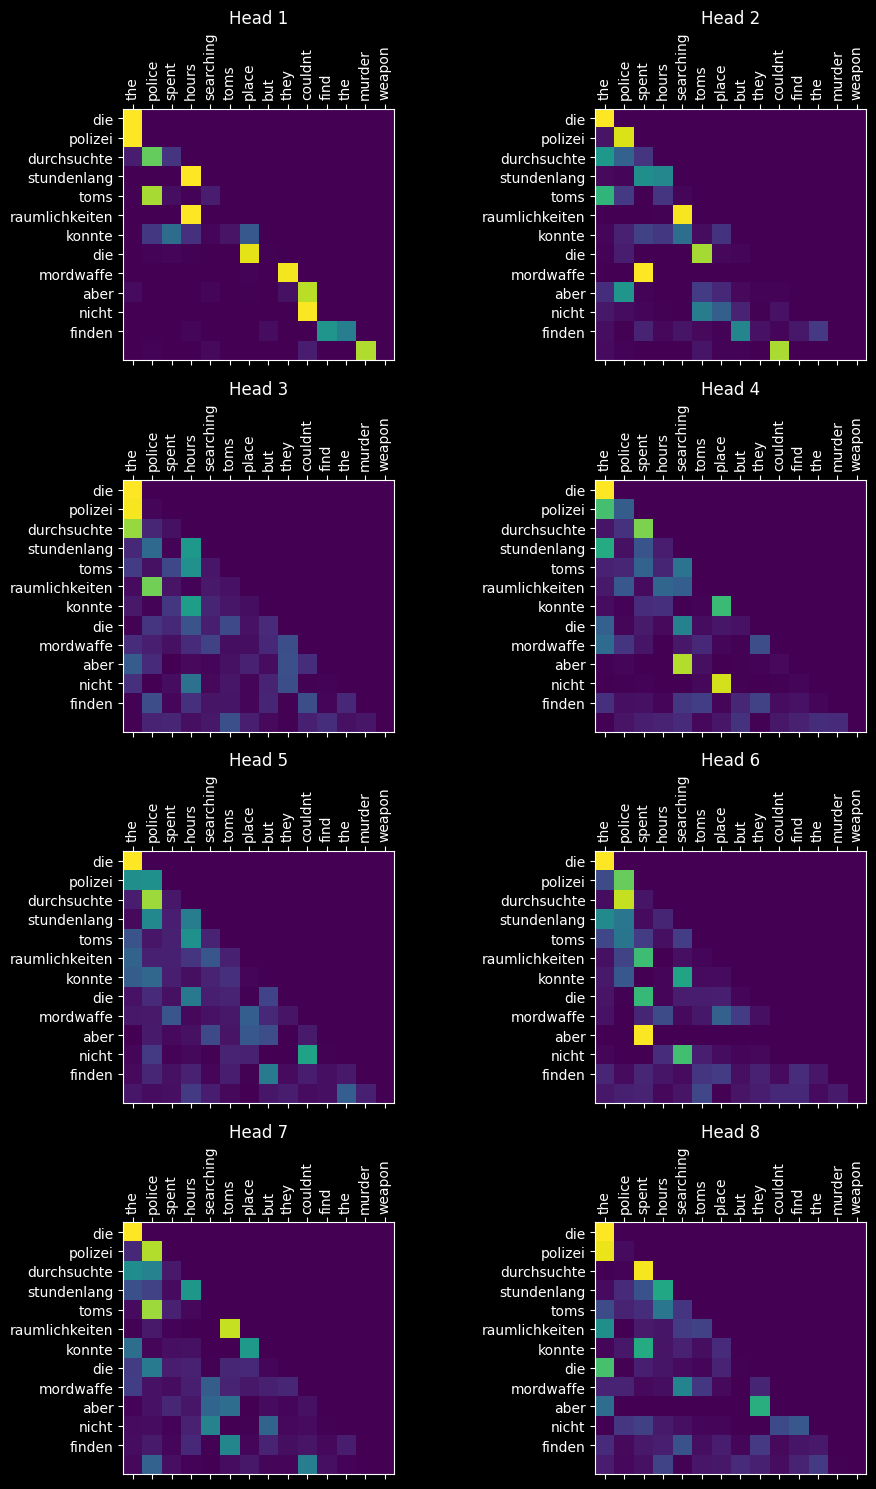

In [37]:
def show_plot(model=loaded_fit_model, start=1, end=110, n=1,  ####sample_decoder_input[:,:-1]
             layer='decoder_layer5_block2', plt_function=plot_attention_weights,
             figsize=(15, 15), nrows=2, ncols=4):
    random_integers = [random.randint(start, end) for _ in range(n)]
    for n in random_integers:
        print(n)
        sample_encoder_input = X1[n:n+1]  # Select a sample input
        sample_decoder_input = X2[n:n+1] ###[:,:-1]  # Select a corresponding target input
        print('sample_decoder_input:\n', sample_decoder_input)
        tf.config.run_functions_eagerly(True)
        prediction_out = loaded_fit_model(
            [sample_encoder_input, sample_decoder_input], training=False)
        print('prediction_out:\n', prediction_out.shape)
        predicted_id = np.argmax(prediction_out, axis=-1)
        print('predicted_id:\n', predicted_id)
        print('predicted label:\n', y[n:n+1])
        attention_weights = loaded_fit_model.attention_weights
        layer = list(attention_weights.keys())[-1]
        attention_weights_n = attention_weights[layer].numpy()
        # print('attention_weights_n:', attention_weights_n)
        tf.config.run_functions_eagerly(False)
        # attention_weights_n = trained_transformer.decoder.dec_layers[-1].last_attn_scores
        # attention_weights_n = tf.squeeze(attention_weights_n, axis=0)
        print('attn_scores: ' , attention_weights_n.shape)
        plt_function(sample_encoder_input, 
                               sample_decoder_input, 
                               attention_weights_n,
                    figsize=figsize, nrows=nrows, ncols=ncols)
        
show_plot(n=1, figsize=(10, 15), nrows=4, ncols=2)

13
sample_decoder_input:
 [[   1 1215   25   67   17  719  168   32    5   67   65  703  120  127
     5   47  106  290    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
prediction_out:
 (1, 76, 4139)
predicted_id:
 [[1215   25   67  244   74  168   32   10   67   65  703  120  289    5
   127  106  230    7    6    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2   10    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    3    2    2    2
     2    2    2    2    2    2]]
predicted label:
 [[1215   25   67   17  719  168   32    5   67   65  703  120  127    5
    47  106  290    2    0    0    0    0    0    

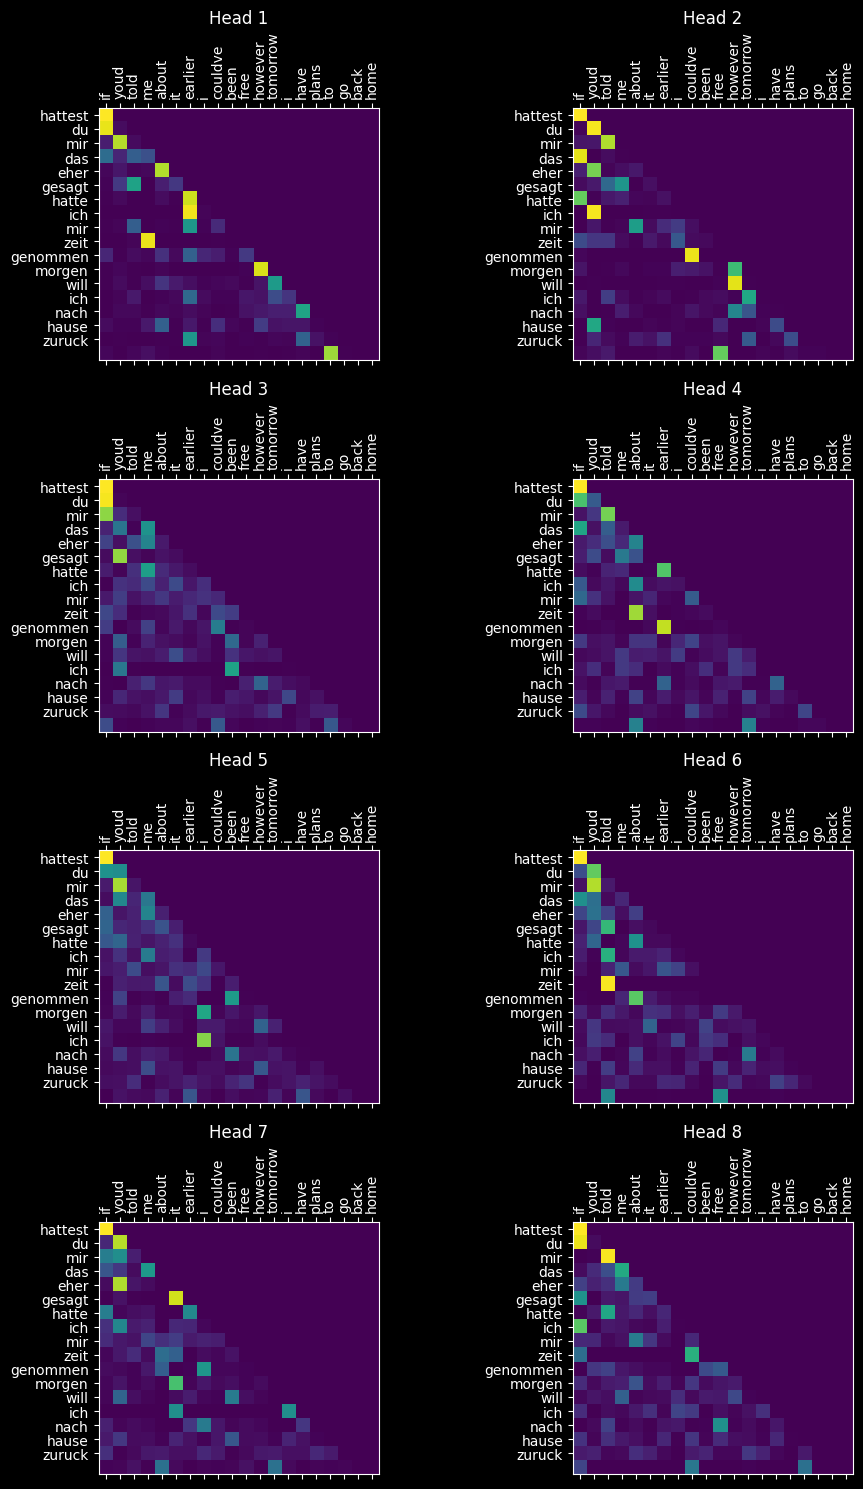

In [40]:
show_plot(n=1, figsize=(10, 15), nrows=4, ncols=2)